## Tâche 9 : ph_dos
Objectif : calculer les températures de Debye et d'Einstein telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique. Représenter les trois courbes de chaleur spécifique (celle correspondant à l'objet téléchargé ainsi que celles obtenues à partir des modèles de Debye et d'Einstein). Représenter les trois densités d'états de phonons correspondantes.

In [1]:
import numpy as np
from mp_api.client import MPRester
from scipy.optimize import minimize
from scipy import integrate
from scipy.integrate import quad
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
# clé API Materials Project
mp_key = "hbfwQnxIfLcB2CMDIPBvWEJViltnasHl" # Clé API
mp_id = "mp-8145"  # Identifiant matériau

In [3]:
# Téléchargement de la structure du matériau
with MPRester(mp_key) as m:
    structure = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Calcul des températures d'Einstein et de Debye

Ci-dessous, les modèles pour déterminer les températures d'Einstein/Debye. La différence principale est la forte hypothèse utilisée dans le modèle d'Einstein selon laquelle tous les atomes du cristal vibrent à la même fréquence caractéristique $\omega_0$.

Modèle d'Einstein :
$$
\frac{C_v}{3N_aR} = \left(\frac{\Theta_E}{T}\right)^2 \frac{exp(\frac{\Theta_E}{T})}{\left(exp(\frac{\Theta_E}{T})-1\right)^2}
$$
Où $\Theta_E$ est la température d'Einstein recherchée.

Modèle de Debye :
$$
\frac{C_v}{3N_aR} = 9 \left(\frac{T}{\Theta_D}\right)^3 \int_0^{\frac{\Theta_D}{T}} \frac{x^4 exp(x)}{(exp(x) - 1)^2} dx
$$
Où $\Theta_D$ est la température de Debye recherchée.

On observe que le modèle de Debye est plus réaliste à basse température. En effet, il ne fait pas la forte hypothèse de la fréquence de vibration commune. Cela lui permet d'évoluer en $T^3$ à basse température ce qui se rapproche plus de la réalité.

La valeur optimale de Theta_E est : 379.43 K
La valeur optimale de Theta_D est : 514.12 K


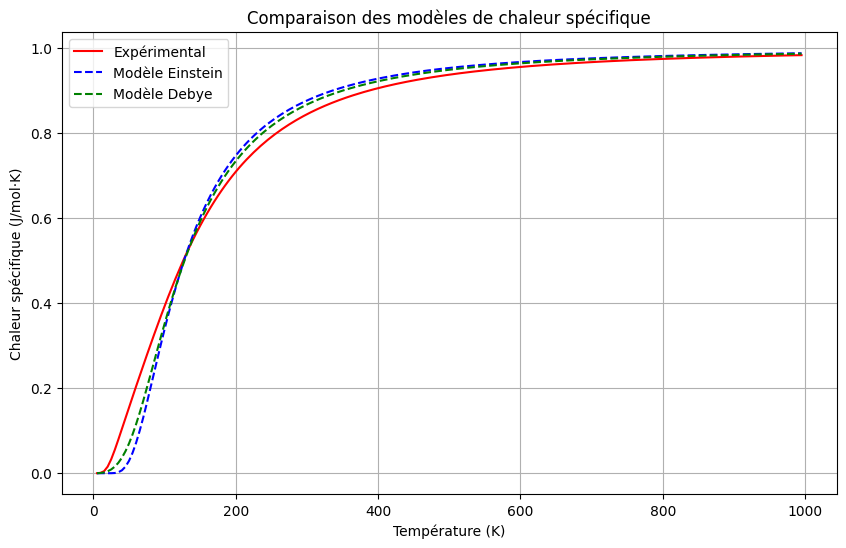

In [4]:
# Définition des constantes
R = 8.314  # Constante des gaz parfaits (J/(mol·K))
temperatures = np.arange(5, 1000, 5)  # Températures de 5 K à 995 K
nat = len(structure)  # Nombre d'atomes dans la structure

# Récupération des capacités calorifiques expérimentales normalisées
cv_experimental = np.array([ph_dos.cv(T) for T in temperatures]) / (3 * nat * R)

### MODÈLE D'EINSTEIN ###
def Einstein_model(Theta_E, T):
    """ Modèle d'Einstein pour la chaleur spécifique. """
    return ((Theta_E/T)**2 * np.exp(Theta_E/T)) / ((np.exp(Theta_E/T) - 1)**2)

def error_func_einstein(Theta_E, temps, cv_exp):
    """ Fonction d'erreur pour ajuster Theta_E en minimisant la différence entre modèle et données. """
    cv_theo = Einstein_model(Theta_E, temps)
    return np.sum((cv_theo - cv_exp)**2)

# Optimisation de Theta_E
Theta_E_optimal = minimize(error_func_einstein, x0=100, args=(temperatures, cv_experimental)).x[0]
Einstein_pred = Einstein_model(Theta_E_optimal, temperatures)

### MODÈLE DE DEBYE ###
def Debye_model(Theta_D, T_exp):
    return (3 * (T_exp /Theta_D)**3) * integrate.quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, Theta_D / T_exp)[0]

def error_func(Theta_D, temps_exp, cv_exp):
    squared_errors = [(Debye_model(Theta_D, temps_exp[i]) - cv_exp[i])**2 for i in range(len(temps_exp))]
    return sum(squared_errors)

# Optimisation de Theta_D
Theta_D_optimal = minimize(error_func, 100, args=(temperatures, cv_experimental)).x[0]
Debye_pred = np.array([Debye_model(Theta_D_optimal, temp) for temp in temperatures])

# Affichage des résultats optimaux
print(f"La valeur optimale de Theta_E est : {Theta_E_optimal:.2f} K")
print(f"La valeur optimale de Theta_D est : {Theta_D_optimal:.2f} K")

### AFFICHAGE DES RÉSULTATS ###
plt.figure(figsize=(10, 6))
plt.plot(temperatures, cv_experimental, linestyle='-', color="red", label="Expérimental")
plt.plot(temperatures, Einstein_pred, linestyle='--', color="blue", label="Modèle Einstein")
plt.plot(temperatures, Debye_pred, linestyle='--', color='green', label="Modèle Debye")

plt.xlabel('Température (K)')
plt.ylabel('Chaleur spécifique (J/mol·K)')
plt.legend()
plt.title('Comparaison des modèles de chaleur spécifique')
plt.grid(True)
plt.show()


### Densités d'états de phonons 

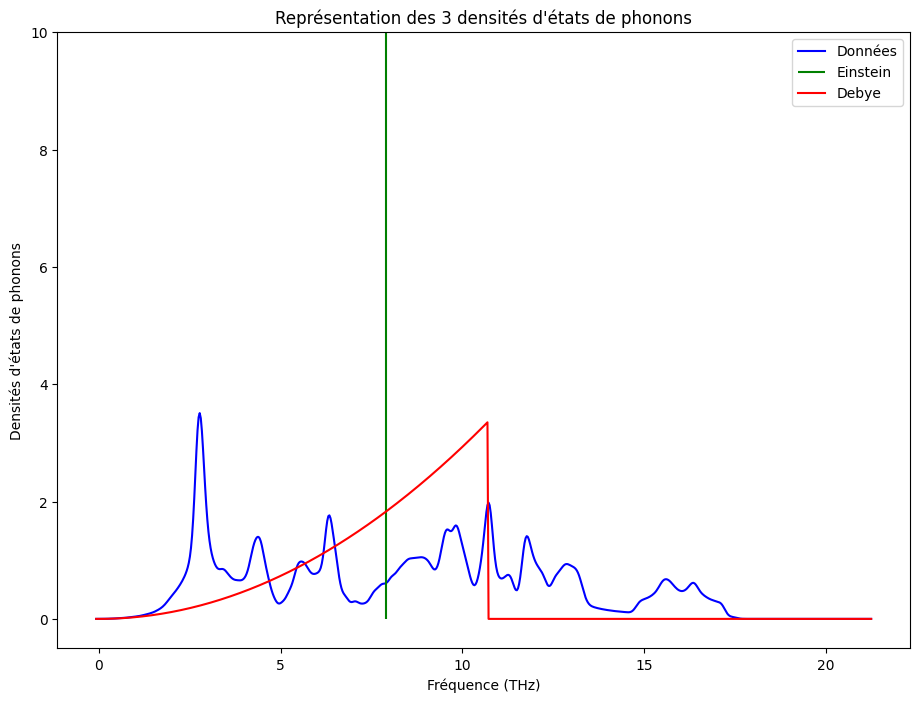

In [5]:
# Constantes
k_B = 1.380649e-23  # J/K
h_b = 1.055e-34     # J.s
THz = 1e-12         # Facteur de conversion pour THz en Hz
THZ_KB_HB = THz * k_B / h_b

# Données de fréquence et de densité
Freq = ph_dos.frequencies
Dens = ph_dos.densities

# Conversion des températures en fréquences effectives
T_e = Theta_E_optimal * THZ_KB_HB
F_e = T_e / (2 * np.pi)
T_d = Theta_D_optimal * THZ_KB_HB

# Calcul de la densité d'états de Debye
T_frequencies = 2 * np.pi * Freq
dens_d = np.where(T_frequencies < T_d, (9 * nat * T_frequencies**2 / T_d**3), 0)

# Plots
plt.figure(figsize=(11, 8))
plt.plot(Freq, Dens, color="blue", label="Données")
plt.vlines(F_e, 0, 3 * nat, color="green", label="Einstein")
plt.plot(Freq, dens_d * (2 * np.pi), color='red', label="Debye")
plt.title("Représentation des 3 densités d'états de phonons")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()

In [6]:
aire_sous_la_courbe = np.trapz(dens_d * (2 * np.pi), Freq)
print("L'aire sous la courbe rouge est :", aire_sous_la_courbe)

aire_sous_la_courbe = np.trapz(Dens, Freq)
print("L'aire sous la courbe bleue est :", aire_sous_la_courbe)

L'aire sous la courbe rouge est : 11.98998263842875
L'aire sous la courbe bleue est : 11.999993936224627


pour le modèle d'Einstein (vert), tous les phonons vibrent à la même fréquence. C'est pourquoi on observe un delta de Dirac.

Pour le modèle de Debye (rouge), la densité des modes vibratoires suit une parabole. Qui est une grossière approximation.

En comparant la courbe expérimentale (bleue) et la courbe de Debye (rouge), on observe que l'aire sous ces courbes sont identiques et aussi que ces deux courbes coïncident pour les fréquences proches de zéro.